# Latent space analysis using PCA

## 1. Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

/home/descartes/anaconda3/envs/coma/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/descartes/anaconda3/envs/coma/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
from coma.dataset import TrainingSmilesDataset
from coma.vae import SmilesAutoencoder
from coma.properties import similarity

## 2. Configure GPU (if available)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Set a target property

In [4]:
PROPERTY_NAME = "drd2"
#PROPERTY_NAME = "qed"
#PROPERTY_NAME = "logp04"
#PROPERTY_NAME = "logp06"

## 4. Describe file information for inputs

In [5]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "data", PROPERTY_NAME))
input_ckpt_dir = f"outputs_1_pretraining_{PROPERTY_NAME}"

In [6]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")

In [7]:
filepath_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

## 5. Describe file information for outputs

In [8]:
output_dir = f"outputs_3_latent_space_analysis_{PROPERTY_NAME}"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [9]:
filepath_scatter = os.path.join(output_dir, "scatter.png")
filepath_box     = os.path.join(output_dir, "box.png")

## 6. Load the training dataset

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_char2idx, device=device)

## 7. Load a pretrained generator of COMA

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_ckpt)

## 8. Calculate latent vectors

In [12]:
latent_vectors_src = []
latent_vectors_tar = []

for batch in tqdm.tqdm(DataLoader(dataset, batch_size=100, shuffle=False, drop_last=False, pin_memory=use_cuda)):
    len_src = batch["length_s"]
    len_tar = batch["length_t"]
    smi_src = dataset.encode(batch["smiles_s"], batch["length_s"].max())
    smi_tar = dataset.encode(batch["smiles_t"], batch["length_t"].max())
    
    mean_src, logvar_src = generator.transform(smi_src, len_src)
    mean_tar, logvar_tar = generator.transform(smi_tar, len_tar)
    
    z_src = mean_src + np.random.randn(*logvar_src.shape) * np.exp(0.5 * logvar_src)
    z_tar = mean_tar + np.random.randn(*logvar_tar.shape) * np.exp(0.5 * logvar_tar)
    
    latent_vectors_src.append(z_src)
    latent_vectors_tar.append(z_tar)
    
latent_vectors_src = np.concatenate(latent_vectors_src)
latent_vectors_tar = np.concatenate(latent_vectors_tar)

100%|██████████| 6881/6881 [01:22<00:00, 83.51it/s]


## 9. Random sampling to take 20 pairs of (src, tar)

In [13]:
number_of_samples = 20
idx = np.random.choice(len(dataset), number_of_samples)

samples_src = latent_vectors_src[idx]
samples_tar = latent_vectors_tar[idx]

smiles_src = dataset.df.loc[idx, "smiles_src"]
smiles_tar = dataset.df.loc[idx, "smiles_tar"]

labels_src = [f"S{i}" for i in range(number_of_samples)]
labels_tar = [f"T{i}" for i in range(number_of_samples)]

## 10. Principal component analysis

In [14]:
pca = PCA(n_components=2, random_state=2022)
pca = pca.fit(np.concatenate((samples_src, samples_tar)))

points_src = pca.transform(samples_src)
points_tar = pca.transform(samples_tar)

## 11. Visualize a scatter plot

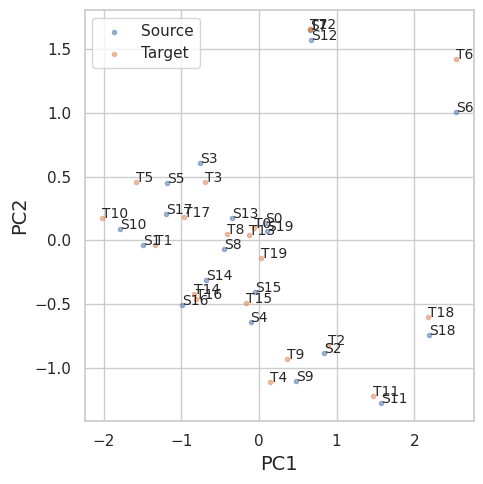

In [15]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(points_src[:,0], points_src[:,1], marker=".", label="Source", alpha=0.5)
for label, (pos_x,pos_y) in zip(labels_src, points_src):
    ax.text(pos_x, pos_y, label, fontsize=10)

ax.scatter(points_tar[:,0], points_tar[:,1], marker=".", label="Target", alpha=0.5)
for label, (pos_x,pos_y) in zip(labels_tar, points_tar):
    ax.text(pos_x, pos_y, label, fontsize=10)

ax.legend(loc='best')

ax.set_xlabel("PC1", fontsize=14)
ax.set_ylabel("PC2", fontsize=14)

plt.tight_layout()
plt.savefig(filepath_scatter, dpi=300)
plt.show()

## 12. Compute the Euclidean distance and Tanimoto similarity for each pair

In [16]:
data_s_d = []

smiles_src = list(zip(labels_src, smiles_src, points_src[:,0], points_src[:,1]))
smiles_tar = list(zip(labels_tar, smiles_tar, points_tar[:,0], points_tar[:,1]))

for label_src, smi_src, pos_x_src, pos_y_src in smiles_src:
    for label_tar, smi_tar, pos_x_tar, pos_y_tar in smiles_tar:
        s = similarity(smi_src, smi_tar)
        d = np.sqrt((pos_x_src - pos_x_tar)**2 + (pos_y_src - pos_y_tar)**2)
        data_s_d.append((label_src,smi_src,label_tar, smi_tar, s, d))
        
df_sd = pd.DataFrame.from_records(data_s_d)
df_sd = df_sd.rename(columns={0:"Label(source)", 1:"SMILES(source)", 2:"Label(target)", 3:"SMILES(target)", 4:"Tanimoto Similarity", 5:"Euclidean Distance"})

df_sd.loc[df_sd.index[df_sd["Tanimoto Similarity"] >= 0.4], "Group"] = "Similar"
df_sd.loc[df_sd.index[df_sd["Tanimoto Similarity"] < 0.4], "Group"] = "Dissimilar"

## 13. Visualize a box plot (x-axis: Tanimoto, y-axis: Euclidean)

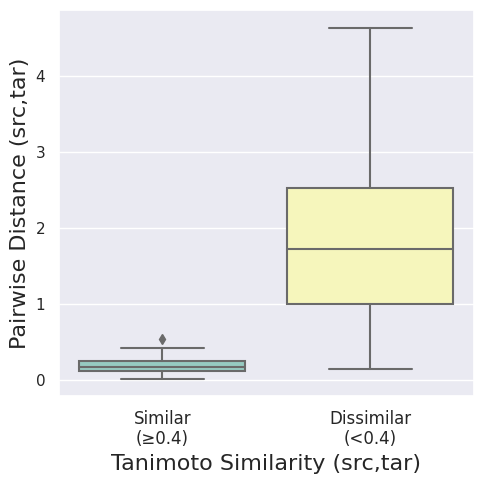

In [17]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=df_sd, x="Group", y="Euclidean Distance", ax=ax, palette=sns.color_palette("Set3"))

ax.set_xlabel("Tanimoto Similarity (src,tar)", fontsize=16)
ax.set_ylabel("Pairwise Distance (src,tar)", fontsize=16)

ax.set_xticklabels(["Similar\n(≥0.4)", "Dissimilar\n(<0.4)"], fontsize=12)

plt.tight_layout()
plt.savefig(filepath_box, dpi=300)
plt.show()